# Bitcoin Machine Learning Golden Cross Algorithmic Trading

## Background

In this workbook, we've trained support vector machine (SVM) model to make trading predictions, backtested the results, and then evaluated its performance compared to that of a logistic regression model for BTC.

## References

* [SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

* [SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

In [223]:
# Imports
import pandas as pd
from pathlib import Path
import san

### Read the CSV file into Pandas DataFrame

In [224]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = san.get(
    "ohlcv/bitcoin",
    from_date="2018-12-01",
    to_date="2021-12-01",
    interval="1d"
)

# Review the DataFrame
trading_df.head()

,openPriceUsd,closePriceUsd,highPriceUsd,lowPriceUsd,volume,marketcap
datetime,,,,,,
2018-12-01 00:00:00+00:00,4024.464242,4214.671932,4309.377312,3967.385777,5.375314e+09,7.334619e+10
2018-12-02 00:00:00+00:00,4200.733180,4139.878064,4302.308536,4110.978473,5.262698e+09,7.205049e+10
2018-12-03 00:00:00+00:00,4140.968062,3894.130907,4155.979284,3839.515704,5.089571e+09,6.777905e+10
2018-12-04 00:00:00+00:00,3889.157782,3956.893870,4075.627655,3832.749938,5.028069e+09,6.887829e+10
2018-12-05 00:00:00+00:00,3958.894725,3753.994827,3969.535852,3753.994827,5.302482e+09,6.535250e+10


### Add a daily return values column to the DataFrame

In [225]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["closePriceUsd"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,openPriceUsd,closePriceUsd,highPriceUsd,lowPriceUsd,volume,marketcap,actual_returns
datetime,,,,,,,
2018-12-02 00:00:00+00:00,4200.733180,4139.878064,4302.308536,4110.978473,5.262698e+09,7.205049e+10,-0.017746
2018-12-03 00:00:00+00:00,4140.968062,3894.130907,4155.979284,3839.515704,5.089571e+09,6.777905e+10,-0.059361
2018-12-04 00:00:00+00:00,3889.157782,3956.893870,4075.627655,3832.749938,5.028069e+09,6.887829e+10,0.016117
2018-12-05 00:00:00+00:00,3958.894725,3753.994827,3969.535852,3753.994827,5.302482e+09,6.535250e+10,-0.051277
2018-12-06 00:00:00+00:00,3752.957618,3523.587653,3877.217892,3521.101724,5.881809e+09,6.134725e+10,-0.061377


,openPriceUsd,closePriceUsd,highPriceUsd,lowPriceUsd,volume,marketcap,actual_returns
datetime,,,,,,,
2021-11-27 00:00:00+00:00,53788.100861,54815.079305,55278.488924,53741.326475,3.056086e+10,1.035176e+12,0.023247
2021-11-28 00:00:00+00:00,54813.024702,57248.458376,57393.843751,53680.466521,2.811689e+10,1.081180e+12,0.044393
2021-11-29 00:00:00+00:00,57291.904735,57806.566215,58758.660146,56856.369563,3.237084e+10,1.091774e+12,0.009749
2021-11-30 00:00:00+00:00,57792.231501,57005.425474,59020.328590,56089.483383,3.670859e+10,1.076689e+12,-0.013859
2021-12-01 00:00:00+00:00,56907.966734,57229.829899,59039.431694,56553.080774,3.685820e+10,1.080978e+12,0.003937


---

### Generating the Features and Target Sets

In [226]:
# Define a window size of 50
short_window = 50

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["closePriceUsd"].rolling(window=short_window).mean()

In [227]:
# Define a window size of 200
long_window = 200

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["closePriceUsd"].rolling(window=long_window).mean()

In [228]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [229]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
datetime,,
2019-06-19 00:00:00+00:00,7713.055810,4969.832575
2019-06-20 00:00:00+00:00,7795.545075,4996.768986
2019-06-21 00:00:00+00:00,7888.325162,5028.021115
2019-06-22 00:00:00+00:00,7986.993194,5061.745101
2019-06-23 00:00:00+00:00,8087.477265,5097.251982


,sma_fast,sma_slow
datetime,,
2021-11-27 00:00:00+00:00,60733.733652,45983.186780
2021-11-28 00:00:00+00:00,60779.338331,46023.676402
2021-11-29 00:00:00+00:00,60840.038071,46064.128275
2021-11-30 00:00:00+00:00,60830.450791,46099.752736
2021-12-01 00:00:00+00:00,60854.226253,46152.100952


#### Create the target set

In [230]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

In [231]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [232]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [233]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [234]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [235]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-06-19 00:00:00+00:00


In [236]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-09-19 00:00:00+00:00


In [237]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
datetime,,
2019-06-19 00:00:00+00:00,7713.055810,4969.832575
2019-06-20 00:00:00+00:00,7795.545075,4996.768986
2019-06-21 00:00:00+00:00,7888.325162,5028.021115
2019-06-22 00:00:00+00:00,7986.993194,5061.745101
2019-06-23 00:00:00+00:00,8087.477265,5097.251982


#### Creating the Testing Datasets

In [238]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
datetime,,
2019-09-19 00:00:00+00:00,10524.851472,8165.232394
2019-09-20 00:00:00+00:00,10520.490909,8197.356318
2019-09-21 00:00:00+00:00,10510.499681,8227.961461
2019-09-22 00:00:00+00:00,10495.424404,8258.779991
2019-09-23 00:00:00+00:00,10470.607194,8287.869189


#### Standardizing the Data

In [239]:
# Imports
from sklearn.preprocessing import StandardScaler

In [240]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [241]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [242]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [243]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.62      0.52      0.56        46
         1.0       0.59      0.68      0.63        47

    accuracy                           0.60        93
   macro avg       0.60      0.60      0.60        93
weighted avg       0.60      0.60      0.60        93



---

### Backtesting a Machine Learning Trading Algorithm

In [244]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [245]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.14      0.22       381
         1.0       0.53      0.89      0.67       424

    accuracy                           0.53       805
   macro avg       0.53      0.51      0.44       805
weighted avg       0.53      0.53      0.45       805



In [246]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
display(predictions_df.head())
display(predictions_df.tail())

,predicted_signal,actual_returns,trading_algorithm_returns
datetime,,,
2019-09-19 00:00:00+00:00,-1.0,0.006684,-0.006684
2019-09-20 00:00:00+00:00,-1.0,-0.008257,0.008257
2019-09-21 00:00:00+00:00,-1.0,-0.015904,0.015904
2019-09-22 00:00:00+00:00,-1.0,0.004815,-0.004815
2019-09-23 00:00:00+00:00,-1.0,-0.033635,0.033635


,predicted_signal,actual_returns,trading_algorithm_returns
datetime,,,
2021-11-27 00:00:00+00:00,1.0,0.023247,0.023247
2021-11-28 00:00:00+00:00,1.0,0.044393,0.044393
2021-11-29 00:00:00+00:00,1.0,0.009749,0.009749
2021-11-30 00:00:00+00:00,1.0,-0.013859,-0.013859
2021-12-01 00:00:00+00:00,1.0,0.003937,0.003937


<AxesSubplot:xlabel='datetime'>

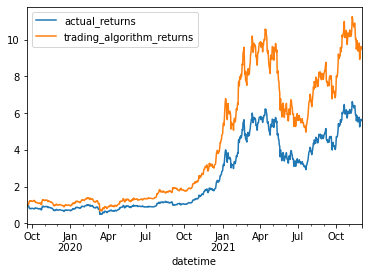

In [247]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [248]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [249]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [250]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [251]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [252]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.61      0.57        46
         1.0       0.55      0.47      0.51        47

    accuracy                           0.54        93
   macro avg       0.54      0.54      0.54        93
weighted avg       0.54      0.54      0.54        93



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [253]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [254]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.91      0.62       381
         1.0       0.55      0.10      0.17       424

    accuracy                           0.48       805
   macro avg       0.51      0.50      0.40       805
weighted avg       0.51      0.48      0.38       805



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [255]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.91      0.62       381
         1.0       0.55      0.10      0.17       424

    accuracy                           0.48       805
   macro avg       0.51      0.50      0.40       805
weighted avg       0.51      0.48      0.38       805



In [256]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.14      0.22       381
         1.0       0.53      0.89      0.67       424

    accuracy                           0.53       805
   macro avg       0.53      0.51      0.44       805
weighted avg       0.53      0.53      0.45       805



### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** No! The SVM model performs a bit better than the logistic regression model since it has a higher accuracy score (53% to 48%).